In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset_one_layer import ThermDataset
%matplotlib inline

In [10]:
args = {'lr':0.01,
        'batch_size':32,
        'epochs':350,
        'noise':0.1,
        'train_size':0.7
        }

# Prepare Data

In [11]:
dataset = ThermDataset(fp='combined_data.xlsx', noise_scale=args['noise'])
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

In [12]:
"""layers = []
for layer in range(1,12):
    train_loader, test_loader, train_dataset, test_dataset, dataset = get_dataloaders(layer)
    layers.append({'layer' : layer,
                 'train loader' : train_loader, 
                 'test loader' : test_loader,
                 'train data' : train_dataset,
                 'test data' : test_dataset, 
                 'data' : dataset
                 })"""

"layers = []\nfor layer in range(1,12):\n    train_loader, test_loader, train_dataset, test_dataset, dataset = get_dataloaders(layer)\n    layers.append({'layer' : layer,\n                 'train loader' : train_loader, \n                 'test loader' : test_loader,\n                 'train data' : train_dataset,\n                 'test data' : test_dataset, \n                 'data' : dataset\n                 })"

# Design Models
(input size, output size, forward pass)

In [13]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin_fin = nn.Linear(60, output_size)


    def forward(self, x):
        output = F.relu(self.lin1(x))
        output = F.relu(self.lin2(output))
        output = F.relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [14]:
n_samples = len(train_dataset)
sepc_size = 66
temp_size = 1

layers = []
for layer in range(1,12):
    layers.append({'layer': layer,
                   'model' : Net(input_size=sepc_size, output_size=temp_size)
                   })

# Training Loops

In [15]:
learning_rate = args['lr']
criterion = nn.MSELoss()
num_epochs = args['epochs']

In [16]:
best_losses = []
for layer in layers:
    best_loss = np.inf
    best_epoch = 0

    print(f'Layer {layer["layer"]}')
    optimizer = torch.optim.Adam(layer['model'].parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for temp_batch, spec_batch in train_loader:
            spec_train = spec_batch
            temp_train = temp_batch[:,layer['layer']-1].reshape(-1,1)

            # forward pass and loss
            temp_pred = layer['model'](spec_train)
            loss = criterion(temp_pred, temp_train)

            # backward pass
            loss.backward()

            # update
            optimizer.step()

            # empty gradients
            optimizer.zero_grad()

        if (epoch+1) % int(num_epochs/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch+1

    best_losses.append(best_loss.item())
    print(f'best loss: {best_loss} in epoch {best_epoch}\n')

Layer 1
epoch: 35, loss = 654.13427734375
epoch: 70, loss = 572.1259155273438
epoch: 105, loss = 497.06298828125
epoch: 140, loss = 490.2137451171875
epoch: 175, loss = 232.50160217285156
epoch: 210, loss = 1005.023681640625
epoch: 245, loss = 955.675048828125
epoch: 280, loss = 1171.810791015625
epoch: 315, loss = 1002.825927734375
epoch: 350, loss = 1903.35009765625
best loss: 56.36175537109375 in epoch 87

Layer 2
epoch: 35, loss = 249.6133575439453
epoch: 70, loss = 335.7270202636719
epoch: 105, loss = 469.462158203125
epoch: 140, loss = 293.76458740234375
epoch: 175, loss = 613.5176391601562
epoch: 210, loss = 341.6160888671875
epoch: 245, loss = 436.9432678222656
epoch: 280, loss = 522.3596801757812
epoch: 315, loss = 128.80435180664062
epoch: 350, loss = 274.19427490234375
best loss: 11.223978996276855 in epoch 53

Layer 3
epoch: 35, loss = 167.58021545410156
epoch: 70, loss = 200.39138793945312
epoch: 105, loss = 246.64349365234375
epoch: 140, loss = 187.62478637695312
epoch: 1

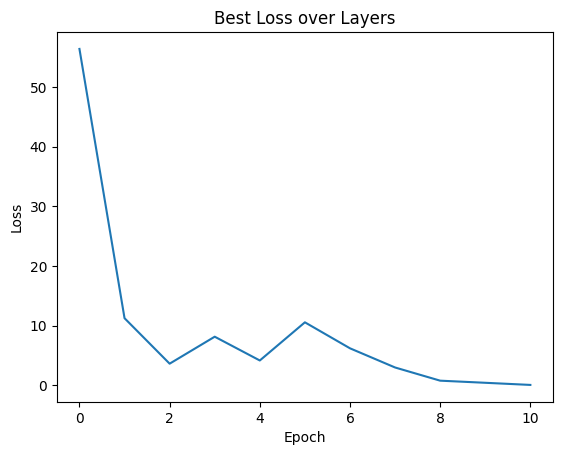

In [17]:
plt.plot(best_losses)

plt.title("Best Loss over Layers")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [21]:
def make_predictions(spec_batch):
    predictions = []
    
    for layer in layers:
        pred = layer['model'](spec_batch)
        predictions.append(pred.detach().numpy())

    return predictions

In [22]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual):
    actual_np = actual.detach().numpy()
    pred_np = pred.detach().numpy()


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, 'r+', label='predicted')

    plt.title(f"Layer")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

In [24]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

for layer in layers:
    with torch.no_grad():
        for temp_batch, spec_batch in test_loader:
            predictions = make_predictions(spec_batch)

            for pred in predictions:
                actual = temp_batch[:,layer['layer']-1].reshape(-1,1)
                loss = criterion(pred, actual)
                print(loss)
                

            """
            total_loss += loss.item() * len(temp_batch)
            n_samples += len(temp_batch)
            current_batch += 1

average_loss = total_loss/n_samples
print(f"average loss: {average_loss}")
"""

TypeError: 'int' object is not callable